# **It’s a Mole! It’s a Mark! IT’S CANCER… or is it? : Understanding Skin Cancer using Data Science with Machine Learning Code**

## Workflow Steps:

1. **Library Imports & Seed Initialization**
   - Loads all necessary libraries and sets random seeds for reproducibility.


2. **Image Loading & Enhancement**
   - Loads images from `benign` and `malignant` folders.
   - Applies enhancement to improve contrast, especially for varied skin tones.

     
3. **EDA - Exploratory Data Analysis**
   - Analyzed global melanoma incidence by race using SCIN and Cancer Atlas data with visualizations.
   - Clustered skin tones using image brightness and mapped them to Fitzpatrick types.


    
5. **Preprocessing & Augmentation**
   - Defines functions to resize, normalize, and augment images.
   - Augmentation includes flipping, brightness/contrast/saturation/hue adjustments.


6. **Model Construction**
   - Builds transfer learning models (VGG16, DenseNet201, Xception, MobileNetV2, ResNet50).
   - Custom classification heads are added and compiled for training.


7. **Train-Test Split & Data Pipelines**
   - Dataset is split into train and test.
   - TensorFlow `tf.data` pipelines are used for efficient batching and augmentation.


8. **Model Training & Evaluation**
   - Each model is trained on the training set and evaluated on the validation set.
   - Plots learning curves and confusion matrices.
   - Saves trained models and stores performance metrics.


9. **Skin Tone Clustering**
   - Computes average skin color per image and clusters them using KMeans.
   - Maps each cluster to a Fitzpatrick skin type (Type I–VI).
   - Groups and saves images into `Grouped_Images/` by skin tone and label.


10. **Skin Tone–wise Model Evaluation**
   - Loads grouped images and evaluates all models across skin tone groups.
   - Accuracy per model per skin tone is calculated and visualized.


11. **Performance Comparison**
   - Creates visualizations to compare model accuracies across skin types and architectures.
   - Helps assess fairness and robustness across diverse skin tones.


**Code Contribution:**
- **EDA** - Akshita Sushil Bhatia & Elakia Vijayalakshmi Mantharachalam
- **Preprocessing & Augmentation** - Rustam Guliyev
- **Modeling** - Elakia Vijayalakshmi Mantharachalam & Andrzej Kolodziej
- **Integration** - Elakia Vijayalakshmi Mantharachalam

# **Imports and Datasets**


Pytho env: 3.10.16  
Hardware :GUP T4 (for better running the models)


## Installation

In [ ]:
!pip install numpy pandas matplotlib seaborn opencv-python scikit-learn tensorflow pillow

### Importing Libraries

In [5]:
# Standard Libraries
import os
import random
import shutil

# Numerical and Image Processing
import numpy as np
import cv2
from PIL import Image
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Machine Learning Utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import chi2_contingency
from sklearn.cluster import KMeans

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
    BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG16, DenseNet201, Xception, MobileNetV2, ResNet50



## Loading the dataset

In [2]:
!git clone https://github.com/Akshi02/COMP4030-DSML.git

Cloning into 'COMP4030-DSML'...
remote: Enumerating objects: 2118, done.
remote: Total 2118 (delta 0), reused 0 (delta 0), pack-reused 2118 (from 2)
Receiving objects: 100% (2118/2118), 109.75 MiB | 39.05 MiB/s, done.


# **EDA- Exploratory Data Analysis**

## Correlation Analysis

### Correlation relation for Dataset : SCIN & Atlas

- Load and clean SCIN and Cancer Atlas datasets.
- Check missing values in SCIN.
- Run chi-square test to assess skin type vs. race association.
- Visualize with a heatmap and a bar chart (growth cases by skin type).



Chi-Square Test between Fitzpatrick Skin Type and Race/Ethnicity
Chi2 Value: 685.9322197067763
p-value: 3.370395068505185e-95


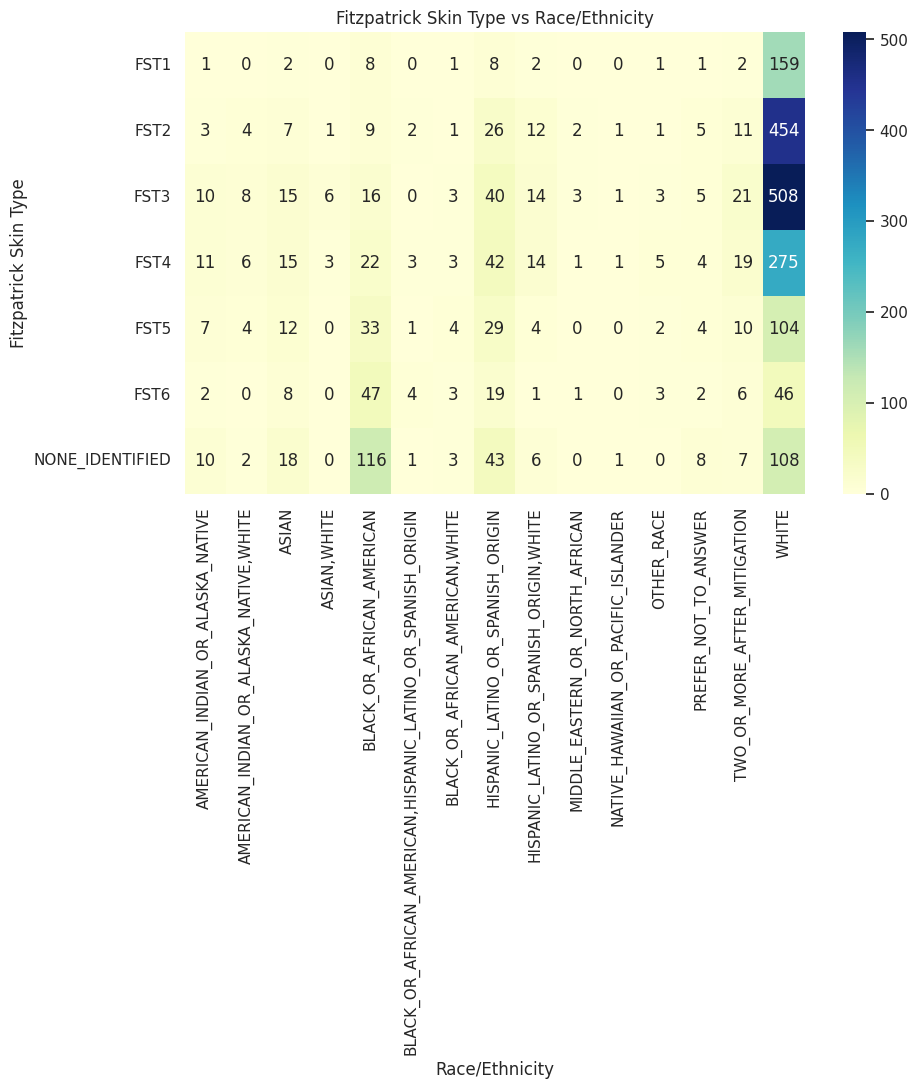

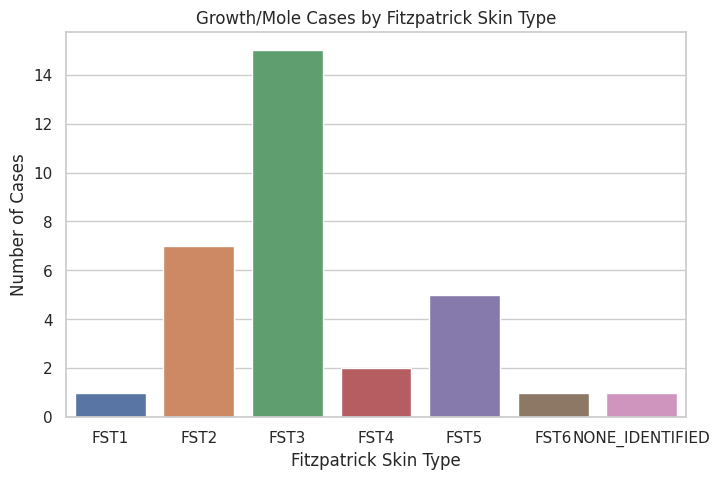

In [6]:
# Full pipeline code from importing to visualization for both datasets

# Set theme for seaborn
sns.set(style="whitegrid")

excel_file_path = "COMP4030-DSML/Cancer-Atlas-3rd-ed_Map-data-download.xlsx"
csv_file_path = "COMP4030-DSML/scin_cases.csv"

# 2. LOAD DATASETS
scin_cases = pd.read_csv(csv_file_path)
cancer_atlas = pd.read_excel(excel_file_path, skiprows=1)

# Rename Cancer Atlas columns for readability
cancer_atlas.columns = [f"col_{i}" if col.startswith("Unnamed") else col.strip().split("\n")[0]
                        for i, col in enumerate(cancer_atlas.columns)]

# Keep relevant columns from Cancer Atlas
cancer_atlas_cleaned = cancer_atlas.rename(columns={
    cancer_atlas.columns[0]: "Country",
    cancer_atlas.columns[2]: "Melanoma_Incidence"
})[["Country", "Melanoma_Incidence"]]
cancer_atlas_cleaned = cancer_atlas_cleaned.dropna()
cancer_atlas_cleaned = cancer_atlas_cleaned[~cancer_atlas_cleaned["Melanoma_Incidence"].isin(["No data"])]
cancer_atlas_cleaned["Melanoma_Incidence"] = pd.to_numeric(cancer_atlas_cleaned["Melanoma_Incidence"], errors='coerce')

# 3. MISSING VALUE ANALYSIS - SCIN
missing_values = scin_cases.isnull().sum()
missing_percentage = (missing_values / len(scin_cases)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
missing_df = missing_df[missing_df["Missing Values"] > 0].sort_values(by='Missing Values', ascending=False)



# 6. CHI-SQUARE TEST - Race vs. Fitzpatrick Skin Type
chi_data = scin_cases[['fitzpatrick_skin_type', 'combined_race']].dropna()
contingency_table = pd.crosstab(chi_data['fitzpatrick_skin_type'], chi_data['combined_race'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Test between Fitzpatrick Skin Type and Race/Ethnicity")
print("Chi2 Value:", chi2)
print("p-value:", p)

# Heatmap of contingency table
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Fitzpatrick Skin Type vs Race/Ethnicity")
plt.ylabel("Fitzpatrick Skin Type")
plt.xlabel("Race/Ethnicity")
plt.show()

# 7. ANALYSIS: SCIN Fitzpatrick Skin Type Distribution (Moles/Growth)
growth_condition = scin_cases[scin_cases['related_category'] == "GROWTH_OR_MOLE"]
skin_type_dist = growth_condition['fitzpatrick_skin_type'].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=skin_type_dist.index, y=skin_type_dist.values)
plt.title("Growth/Mole Cases by Fitzpatrick Skin Type")
plt.xlabel("Fitzpatrick Skin Type")
plt.ylabel("Number of Cases")
plt.show()





### Digital Map for Melanoma Risk by Country

### Global Melanoma Incidence & Race Mapping

- Load and clean SCIN and Cancer Atlas data.
- Estimate dominant race per continent using SCIN distribution.
- Visualize melanoma incidence by country and race using a choropleth map.


In [7]:

# ----------------------------
# Load datasets
# ----------------------------
scin_cases = pd.read_csv("COMP4030-DSML/scin_cases.csv")
cancer_atlas = pd.read_excel( "COMP4030-DSML/Cancer-Atlas-3rd-ed_Map-data-download.xlsx", skiprows=1)

# ----------------------------
# Clean Cancer Atlas
# ----------------------------
cancer_atlas.columns = [f"col_{i}" if col.startswith("Unnamed") else col.strip().split("\n")[0]
                        for i, col in enumerate(cancer_atlas.columns)]
cancer_df = cancer_atlas.rename(columns={
    cancer_atlas.columns[0]: "Country",
    cancer_atlas.columns[2]: "Melanoma_Incidence"
})[["Country", "Melanoma_Incidence"]]
cancer_df = cancer_df[cancer_df["Melanoma_Incidence"].notnull()]
cancer_df = cancer_df[cancer_df["Melanoma_Incidence"] != "No data"]
cancer_df["Melanoma_Incidence"] = pd.to_numeric(cancer_df["Melanoma_Incidence"], errors="coerce")

# ----------------------------
# Map countries to continents using Plotly Gapminder
# ----------------------------
gapminder = px.data.gapminder()[["country", "continent"]].drop_duplicates()
cancer_df = cancer_df.merge(gapminder, left_on="Country", right_on="country", how="left")

# ----------------------------
# Estimate SCIN global race distribution
# ----------------------------
race_dist = scin_cases["combined_race"].value_counts(normalize=True).dropna().to_dict()

# ----------------------------
# Create synthetic continent-to-race from SCIN distribution (manual fallback)
continent_to_race = {
    "Africa": "BLACK_OR_AFRICAN_AMERICAN",
    "Asia": "ASIAN",
    "Europe": "WHITE",
    "North America": "WHITE",
    "South America": "HISPANIC_LATINO_OR_SPANISH_ORIGIN",
    "Oceania": "WHITE"
}

cancer_df["Dominant_Race"] = cancer_df["continent"].map(continent_to_race)

us_race = max(race_dist.items(), key=lambda x: x[1])[0]  # e.g., "WHITE"

cancer_df.loc[cancer_df["Country"] == "United States", "Dominant_Race"] = us_race

# Recalculate Estimated Incidence for US
cancer_df.loc[cancer_df["Country"] == "United States", "Estimated_Incidence"] = (
    cancer_df.loc[cancer_df["Country"] == "United States", "Melanoma_Incidence"] *
    race_dist.get(us_race, 0)
)


# ----------------------------
# Define race color mapping
# ----------------------------
race_color_map = {
    "WHITE": "blue",
    "BLACK_OR_AFRICAN_AMERICAN": "red",
    "ASIAN": "green",
    "HISPANIC_LATINO_OR_SPANISH_ORIGIN": "orange",
    "TWO_OR_MORE_AFTER_MITIGATION": "purple"
}

# ----------------------------
# Plot interactive choropleth
# ----------------------------
fig = px.choropleth(
    cancer_df,
    locations="Country",
    locationmode="country names",
    color="Dominant_Race",
    color_discrete_map=race_color_map,
    hover_name="Country",
    hover_data={
        "Melanoma_Incidence": True,
        "Estimated_Incidence": True,
        "Dominant_Race": True
    },
    title="Melanoma Risk by Country (Color = Dominant Race, Hover = Incidence)"
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=False, projection_type="natural earth"),
    margin={"r": 0, "t": 50, "l": 0, "b": 0}
)

fig.show()


## Skin RGB Analysis + Fitzpatrick Mapping

### Skin Tone Clustering Utilities (Fitzpatrick Mapping)

### Skin Tone Extraction Pipeline
- Load images and extract average skin color (excluding dark moles).
- Cluster by brightness to estimate Fitzpatrick Skin Type (FST I–VI).


In [8]:
# Step 1: Load images
def load_images_from_folder(folder_path):
    images = []
    filenames = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
                    filenames.append(img_path)
    return images, filenames

# Step 2: Extract average skin color (ignoring dark moles)
def extract_avg_skin_color(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    blurred = cv2.GaussianBlur(img_rgb, (15, 15), 0)

    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY)

    masked_rgb = cv2.bitwise_and(blurred, blurred, mask=mask)
    non_zero_pixels = masked_rgb[mask != 0]

    if len(non_zero_pixels) == 0:
        return np.array([0, 0, 0])
    avg_rgb = np.mean(non_zero_pixels, axis=0)
    return avg_rgb

# Step 3: Map RGB centers to Fitzpatrick Skin Types
def map_rgb_to_fitzpatrick(center_rgb):
    brightness = np.mean(center_rgb)
    if brightness >= 220:
        return "Type I (FST1): Very fair skin"
    elif brightness >= 190:
        return "Type II (FST2): Fair skin"
    elif brightness >= 160:
        return "Type III (FST3): Medium skin tone"
    elif brightness >= 130:
        return "Type IV (FST4): Olive skin tone"
    elif brightness >= 100:
        return "Type V (FST5): Brown skin"
    else:
        return "Type VI (FST6): Dark brown or black skin"

### Skin Tone Clustering & Distribution Analysis Pipeline

### Skin Tone Clustering and Distribution Analysis
- Load and preprocess images.
- Extract average skin color, ignoring dark mole regions.
- Cluster skin tones into 6 groups (Fitzpatrick types) using KMeans.
- Map clusters to Fitzpatrick labels and group images by skin type and category.
- Save clustered results and visualize sample images per group.
- Compare predicted Fitzpatrick distribution with SCIN dataset using a bar chart.



Loaded 2109 images.
Extracted average skin colors for 2109 images.

Cluster mapping to Fitzpatrick Types:
Cluster 0: Type III (FST3): Medium skin tone
Cluster 1: Type III (FST3): Medium skin tone
Cluster 2: Type IV (FST4): Olive skin tone
Cluster 3: Type IV (FST4): Olive skin tone
Cluster 4: Type IV (FST4): Olive skin tone
Cluster 5: Type II (FST2): Fair skin

Saved clustering results to 'skin_tone_clusters.csv'.


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



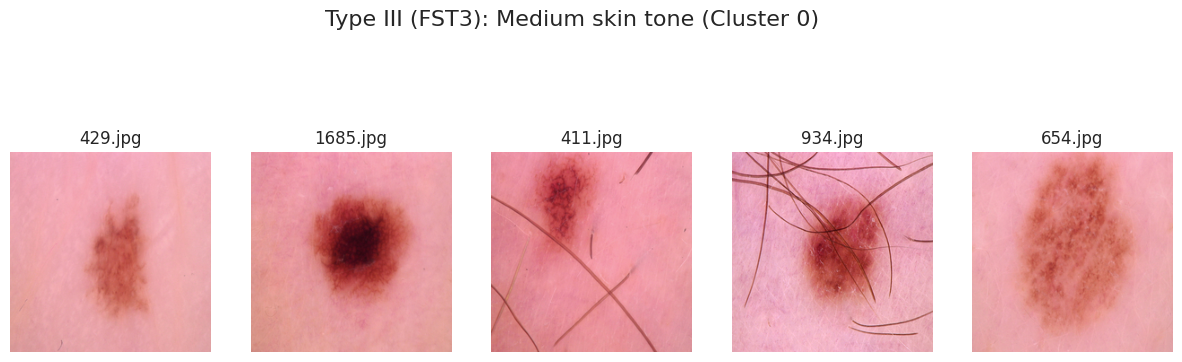

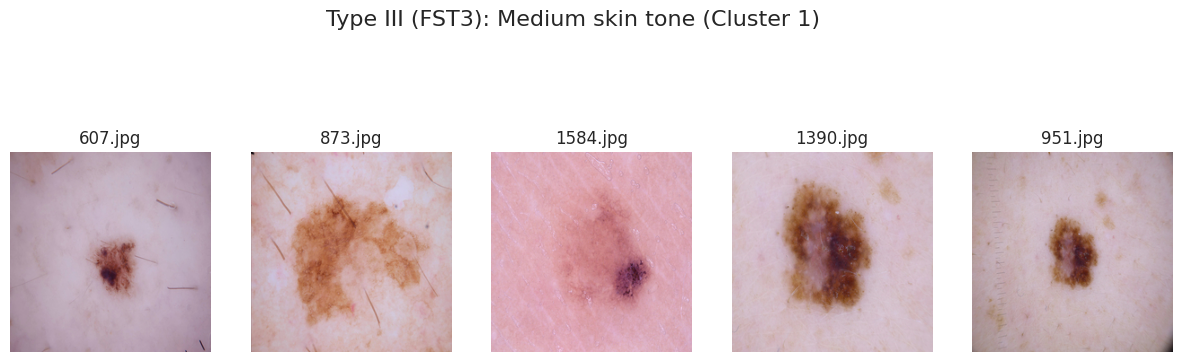

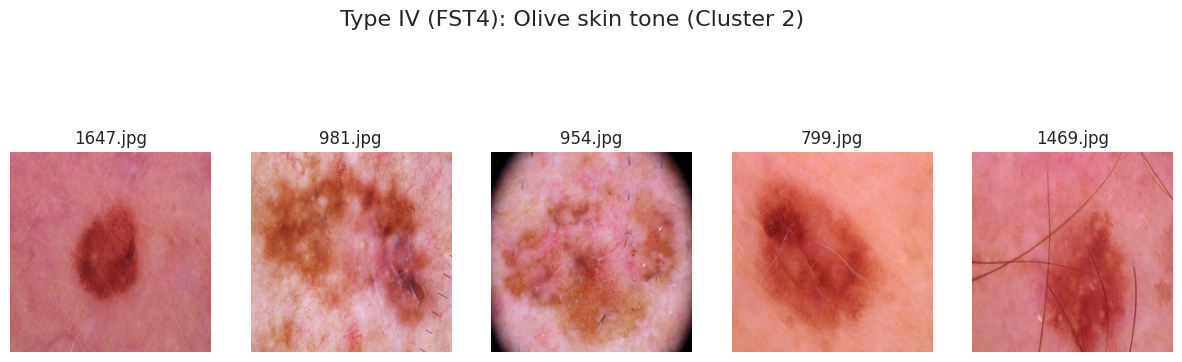

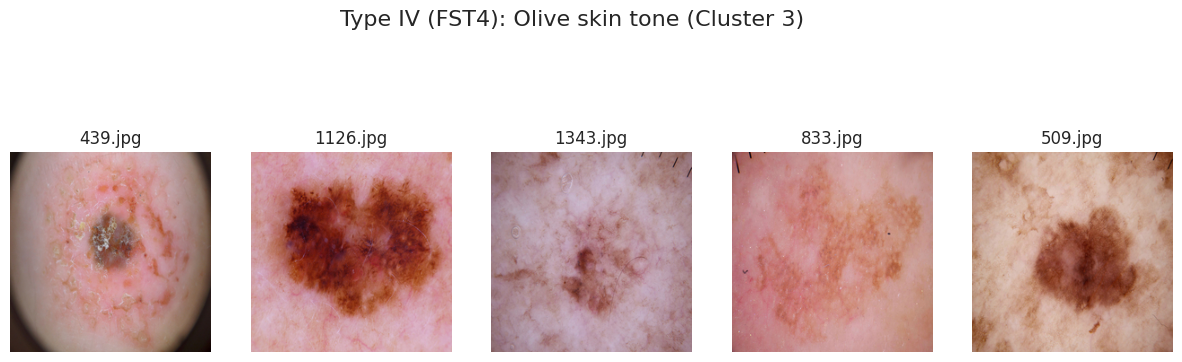

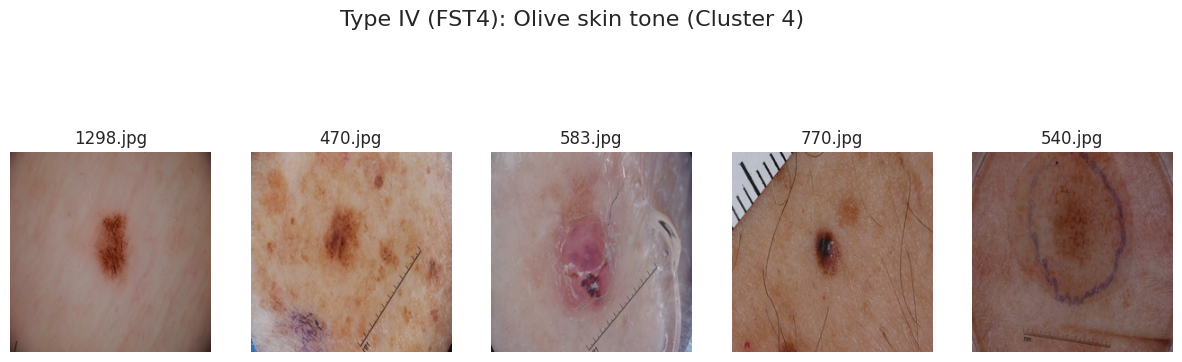

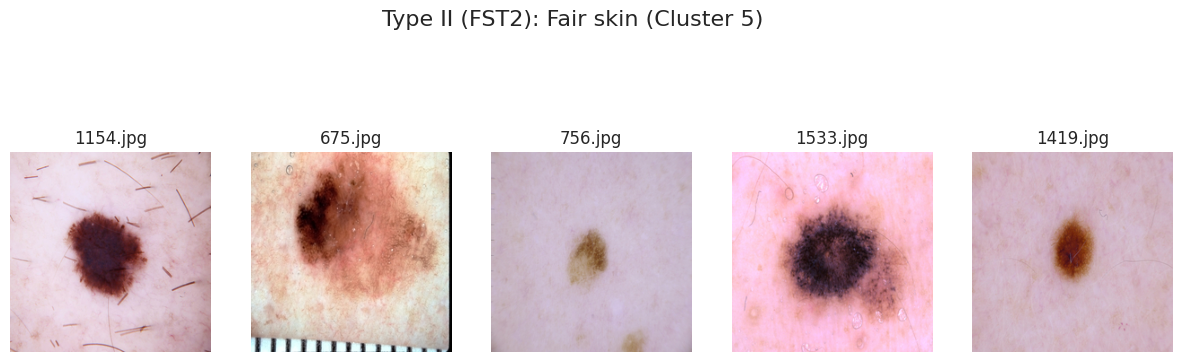


Images successfully grouped into 'Grouped_Images/' based on Fitzpatrick types and categories.


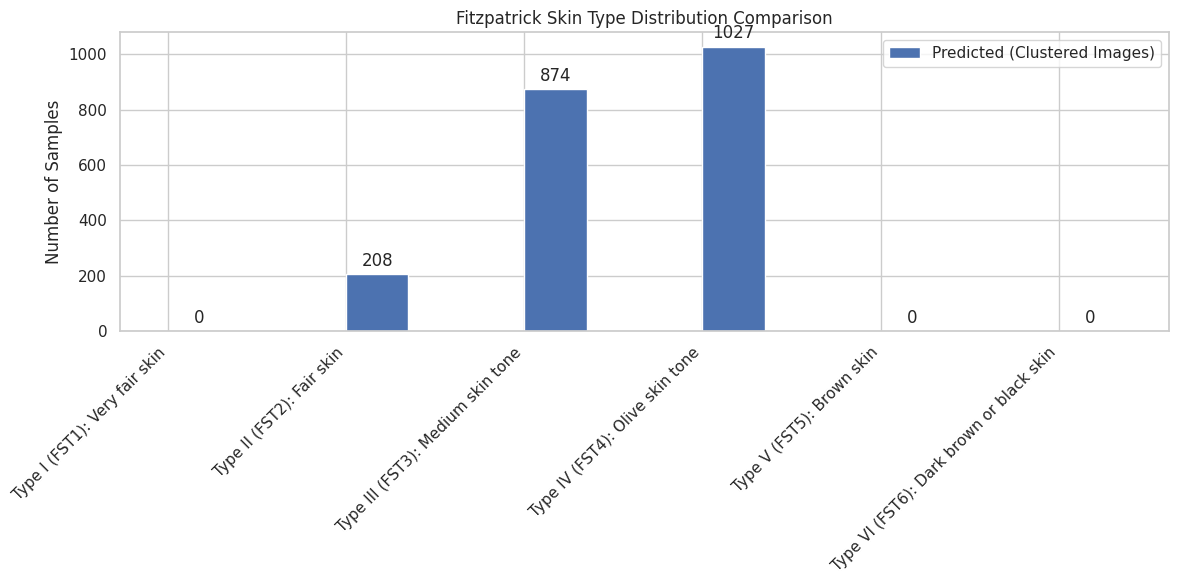

In [10]:
# --- Main Pipeline ---
# Set your dataset path
dataset_path = "COMP4030-DSML/Dataset"

# Load images
images, filenames = load_images_from_folder(dataset_path)
print(f"Loaded {len(images)} images.")

# Extract average skin colors
avg_colors = []
for img in images:
    avg_rgb = extract_avg_skin_color(img)
    avg_colors.append(avg_rgb)

avg_colors = np.array(avg_colors)

# Remove empty entries (bad images)
non_empty_indices = [i for i, color in enumerate(avg_colors) if not np.all(color == 0)]
avg_colors = avg_colors[non_empty_indices]
filenames = [filenames[i] for i in non_empty_indices]

print(f"Extracted average skin colors for {len(avg_colors)} images.")

# Cluster the skin tones
num_clusters = 6  # For FST1-FST6
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(avg_colors)
cluster_centers = kmeans.cluster_centers_

# Map cluster centers to Fitzpatrick types
fitzpatrick_labels = [map_rgb_to_fitzpatrick(center) for center in cluster_centers]

print("\nCluster mapping to Fitzpatrick Types:")
for idx, label in enumerate(fitzpatrick_labels):
    print(f"Cluster {idx}: {label}")

# Save clustering results
df = pd.DataFrame({
    'filename': filenames,
    'cluster_label': labels
})
df.to_csv('skin_tone_clusters.csv', index=False)
print("\nSaved clustering results to 'skin_tone_clusters.csv'.")

# --- Plot random sample images per cluster ---
num_samples_per_cluster = 5

for cluster_idx in range(len(cluster_centers)):
    cluster_name = fitzpatrick_labels[cluster_idx]
    cluster_image_indices = np.where(labels == cluster_idx)[0]

    if len(cluster_image_indices) == 0:
        continue

    selected_indices = random.sample(list(cluster_image_indices), min(num_samples_per_cluster, len(cluster_image_indices)))

    plt.figure(figsize=(15, 5))
    plt.suptitle(f"{cluster_name} (Cluster {cluster_idx})", fontsize=16)

    for i, idx in enumerate(selected_indices):
        img = cv2.imread(filenames[idx])
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_samples_per_cluster, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title(os.path.basename(filenames[idx]))

    plt.show()

# --- Group images into folders ---

def sanitize_folder_name(name):
    return name.replace(":", "").replace("?", "").replace("/", "").replace("\\", "").strip()

output_base = r"Grouped_Images"
os.makedirs(output_base, exist_ok=True)

for idx, file_path in enumerate(filenames):
    label = labels[idx]
    fitz_name = sanitize_folder_name(fitzpatrick_labels[label])  # <- sanitize name here

    if "benign" in file_path.lower():
        category = "benign"
    elif "malignant" in file_path.lower():
        category = "malignant"
    else:
        category = "unknown"

    output_folder = os.path.join(output_base, fitz_name, category)
    os.makedirs(output_folder, exist_ok=True)

    filename_only = os.path.basename(file_path)
    output_path = os.path.join(output_folder, filename_only)
    shutil.copy2(file_path, output_path)


print(f"\nImages successfully grouped into '{output_base}/' based on Fitzpatrick types and categories.")

# --- Plot SCIN true vs predicted Fitzpatrick distributions ---

# Load SCIN true Fitzpatrick data
data ="COMP4030-DSML/scin_cases.csv"
real_data = pd.read_csv(data)
real_skin_types = real_data['fitzpatrick_skin_type'].dropna()
true_counts = real_skin_types.value_counts()

# Predicted distribution
predicted_fitz_names = [fitzpatrick_labels[label] for label in labels]
pred_counts = pd.Series(predicted_fitz_names).value_counts()

# Align categories
fitz_order = [
    "Type I (FST1): Very fair skin",
    "Type II (FST2): Fair skin",
    "Type III (FST3): Medium skin tone",
    "Type IV (FST4): Olive skin tone",
    "Type V (FST5): Brown skin",
    "Type VI (FST6): Dark brown or black skin"
]


pred_counts = pred_counts.reindex(fitz_order, fill_value=0)

# Plot side-by-side bar chart
x = np.arange(len(fitz_order))
width = 0.35

fig, ax = plt.subplots(figsize=(12,6))
rects2 = ax.bar(x + width/2, pred_counts.values, width, label='Predicted (Clustered Images)')

ax.set_ylabel('Number of Samples')
ax.set_title('Fitzpatrick Skin Type Distribution Comparison')
ax.set_xticks(x)
ax.set_xticklabels(fitz_order, rotation=45, ha='right')
ax.legend()

def annotate_bars(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')


annotate_bars(rects2)

plt.tight_layout()
plt.show()

# **Model Training**

## Model Building for Skin Cancer

### Preprocessing, Augmentation, and Model Utilities

The core utility functions used throughout the model training and evaluation pipeline.

- **Seed Setup:** Ensures reproducibility by fixing random seeds for NumPy and TensorFlow.
- **`enhance_image()`:** Enhances input images using CLAHE in the LAB color space to improve skin contrast.
- **`load_images_and_labels()`:** Loads and enhances images from `benign` and `malignant` folders, resizes them, and assigns labels.
- **`preprocess()`:** Converts images to float, resizes them to 224×224, and applies one-hot encoding to labels.
- **`augment()`:** Applies random data augmentation techniques to improve generalization.
- **`build_transfer_model()`:** Builds a transfer learning model using a given pretrained base (e.g., VGG16, ResNet50), followed by pooling, dense, dropout, and softmax layers.
- **`plot_learning_curves()`:** Visualizes training and validation accuracy/loss over epochs.
- **`plot_confusion_matrix()`:** Plots the confusion matrix for predicted vs true labels to assess classification performance.


In [11]:
# Fix random seeds
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

def enhance_image(image: np.ndarray) -> np.ndarray:
    """
    Enhance an image by applying CLAHE to the L-channel in LAB color space.
    """
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    enhanced = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    return enhanced


def load_images_and_labels(dataset_path: str, img_size: tuple = (224, 224)) -> tuple:
    """
    Load images and labels from the given dataset path.
    """
    categories = ['benign', 'malignant']
    data, labels = [], []

    for category in categories:
        folder_path = os.path.join(dataset_path, category)
        if not os.path.exists(folder_path):
            print(f"Warning: Folder {folder_path} does not exist.")
            continue

        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                img = Image.open(file_path).convert("RGB")
                img = img.resize(img_size)
                enhanced = enhance_image(np.array(img))
                data.append(enhanced)
                labels.append(category)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")

    return np.array(data), np.array(labels)


def preprocess(image, label):
    """
    Preprocess function for tf.data pipeline.
    """
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    return image, tf.one_hot(label, depth=2)


def augment(image, label):
    """
    Data augmentation function for tf.data pipeline.
    """
    image = tf.image.random_flip_left_right(image, seed=SEED)
    image = tf.image.random_flip_up_down(image, seed=SEED)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.6)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.3)
    image = tf.image.random_hue(image, max_delta=0.05)

    return image, label


def build_transfer_model(base_model_fn, input_shape=(224, 224, 3)):
    """
    Build a transfer learning model.
    """
    base_model = base_model_fn(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def plot_learning_curves(history, model_name):
    """
    Plot training and validation accuracy and loss curves.
    """
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Plot a confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=['Benign', 'Malignant'],
        yticklabels=['Benign', 'Malignant']
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

### Dataset Preparation: Train-Test Split & TensorFlow Pipelines

The dataset for training and validation.

- **Train-Test Split:** Stratified split of the dataset into 90% training and 10% testing to preserve class balance.
- **Normalization:** Computes mean and standard deviation from the training set and applies them to both train and test sets for consistent input scaling.
- **TensorFlow Data Pipelines:**
  - `train_ds`: Applies preprocessing, augmentation, shuffling, batching, and prefetching.
  - `val_ds`: Applies preprocessing, batching, and prefetching without augmentation.


In [13]:
# Load dataset
path = r"COMP4030-DSML/Dataset"
X, y_labels = load_images_and_labels(path)
X = X.astype(np.float32)

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y_labels)

In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.10, random_state=42
)

# Normalize
mean = np.mean(X_train, axis=(0, 1, 2), keepdims=True)
std = np.std(X_train, axis=(0, 1, 2), keepdims=True)
std[std == 0] = 1e-6

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# Create tf.data pipelines
AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .shuffle(1024)
    .batch(32)
    .prefetch(AUTOTUNE)
)

val_ds = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test))
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(32)
    .prefetch(AUTOTUNE)
)

I0000 00:00:1746134647.351031      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746134647.352084      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


### Model Training & Evaluation Loop

Multiple transfer learning models and evaluates their performance on the validation set.

- **Architectures Used:**
  - VGG16, DenseNet201, Xception, MobileNetV2, ResNet50
- **Training Loop:**
  - Initializes each model using `build_transfer_model()`
  - Trains the model for 10 epochs using `train_ds` and `val_ds`
  - Evaluates model predictions using accuracy and classification report
  - Plots training curves and confusion matrix
  - Saves each trained model in `.h5` format
- **Results Storage:** Accuracy and training history are saved in a dictionary for later comparison.



 Training model: VGG16
Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - accuracy: 0.5288 - loss: 0.7893 - val_accuracy: 0.5972 - val_loss: 0.6476
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 238ms/step - accuracy: 0.5708 - loss: 0.6926 - val_accuracy: 0.6540 - val_loss: 0.6035
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 243ms/step - accuracy: 0.6107 - loss: 0.6387 - val_accuracy: 0.7441 - val_loss: 0.5670
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 227ms/step - accuracy: 0.6722 - loss: 0.6051 - val_accuracy: 0.7630 - val_loss: 0.5414
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - accuracy: 0.6880 - loss: 0.5891 - val_accuracy: 0.7441 - val_loss: 0.5237
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - accuracy: 0.7427 - loss: 0.5333 - val_accuracy: 0.7867 - val_loss: 0.5041
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - accuracy: 0.7158 - loss: 0.5481 - val_accuracy: 0.7820 - val_loss: 0.4887
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 228ms/step - accuracy: 0.7728 -

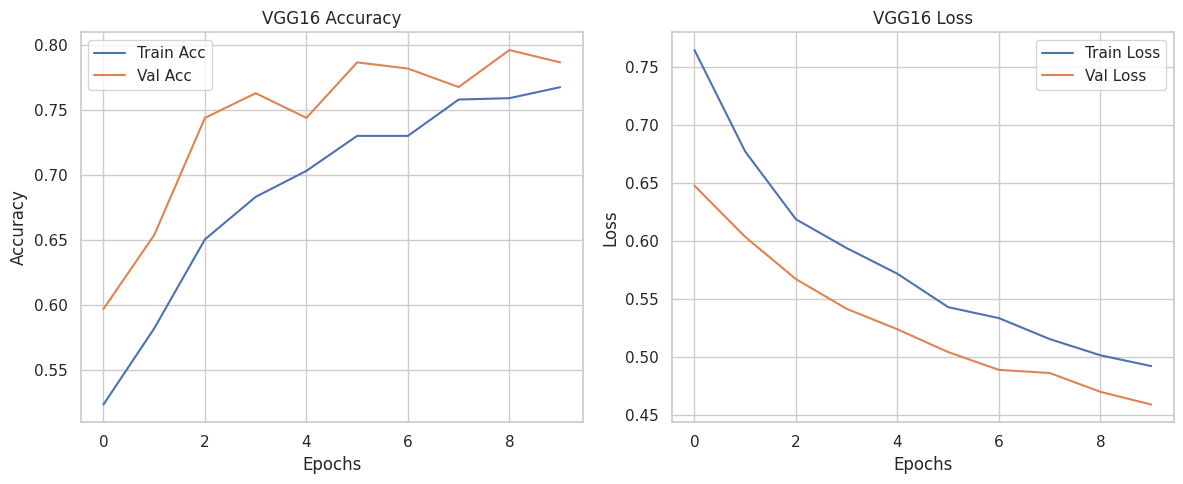

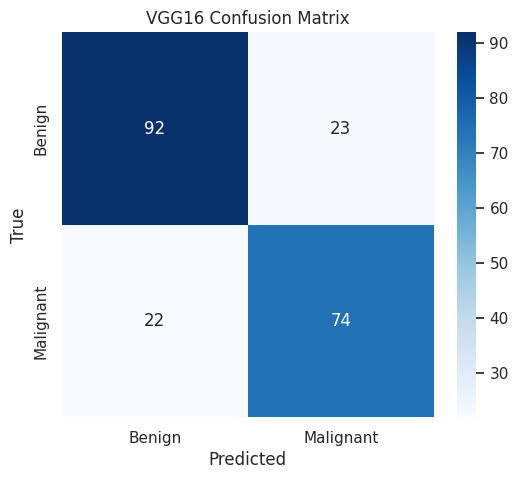


 Training model: DenseNet201
Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 106s 971ms/step - accuracy: 0.6205 - loss: 0.7581 - val_accuracy: 0.7204 - val_loss: 0.5028
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 0.7015 - loss: 0.5728 - val_accuracy: 0.7630 - val_loss: 0.4337
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.7797 - loss: 0.4625 - val_accuracy: 0.7630 - val_loss: 0.4303
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 0.8050 - loss: 0.4317 - val_accuracy: 0.7962 - val_loss: 0.3920
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.7995 - loss: 0.4336 - val_accuracy: 0.7867 - val_loss: 0.4002
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.8160 - loss: 0.4106 - val_accuracy: 0.7820 - val_loss: 0.3899
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.8334 - loss: 0.3617 - val_accuracy: 0.8104 - val_loss: 0.3579
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0

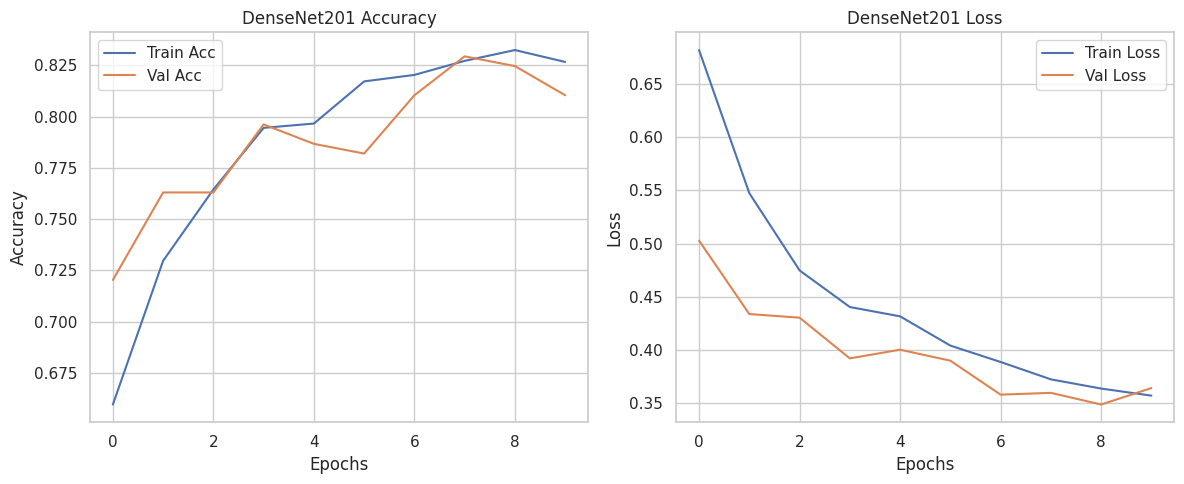

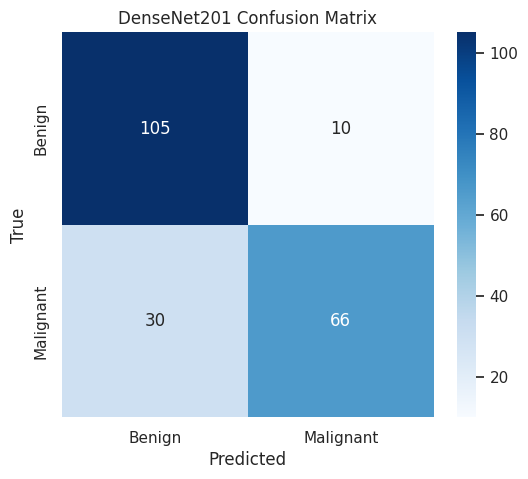


 Training model: Xception
Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 28s 297ms/step - accuracy: 0.5967 - loss: 0.6822 - val_accuracy: 0.7915 - val_loss: 0.4645
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - accuracy: 0.7439 - loss: 0.5198 - val_accuracy: 0.7962 - val_loss: 0.4157
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - accuracy: 0.7678 - loss: 0.4723 - val_accuracy: 0.8152 - val_loss: 0.4033
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - accuracy: 0.7838 - loss: 0.4517 - val_accuracy: 0.8246 - val_loss: 0.3833
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step - accuracy: 0.7921 - loss: 0.4368 - val_accuracy: 0.8341 - val_loss: 0.3757
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - accuracy: 0.8217 - loss: 0.3984 - val_accuracy: 0.8246 - val_loss: 0.3671
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 11s 174ms/step - accuracy: 0.8161 - loss: 0.3973 - val_accuracy: 0.8246 - val_loss: 0.3733
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - accuracy: 0.823

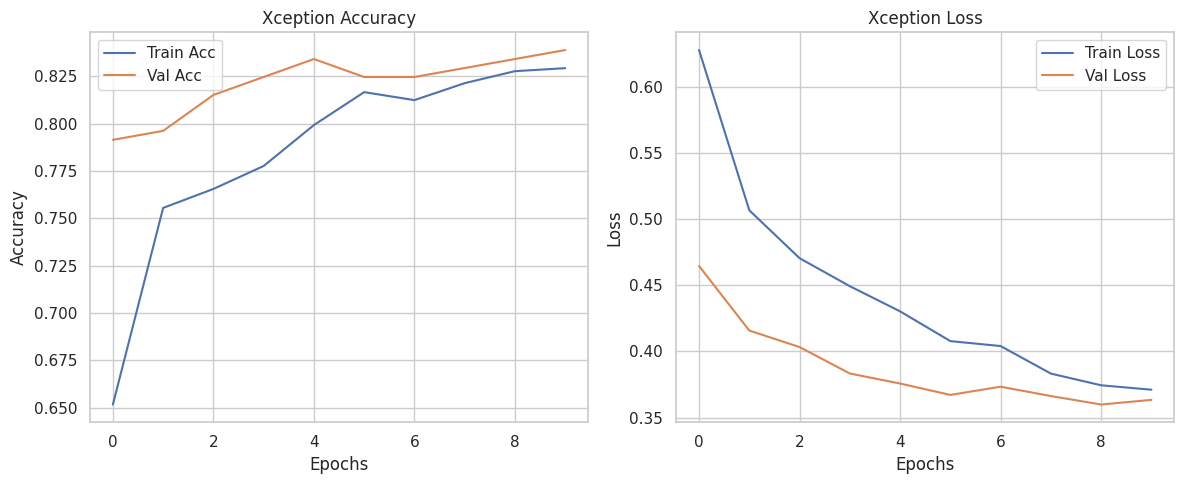

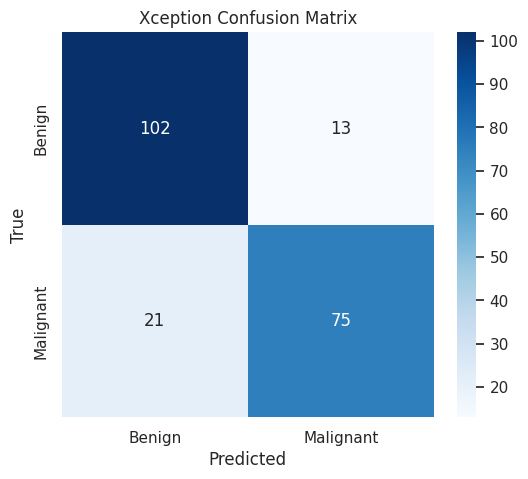


 Training model: MobileNetV2
Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 23s 168ms/step - accuracy: 0.5598 - loss: 0.9208 - val_accuracy: 0.7204 - val_loss: 0.5163
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.6998 - loss: 0.5901 - val_accuracy: 0.7488 - val_loss: 0.4858
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.7531 - loss: 0.5176 - val_accuracy: 0.7820 - val_loss: 0.4717
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7709 - loss: 0.5041 - val_accuracy: 0.7678 - val_loss: 0.4532
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7861 - loss: 0.4505 - val_accuracy: 0.7725 - val_loss: 0.4372
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.7770 - loss: 0.4588 - val_accuracy: 0.7725 - val_loss: 0.4337
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.7966 - loss: 0.4273 - val_accuracy: 0.7678 - val_loss: 0.4172
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.8133 - loss: 0

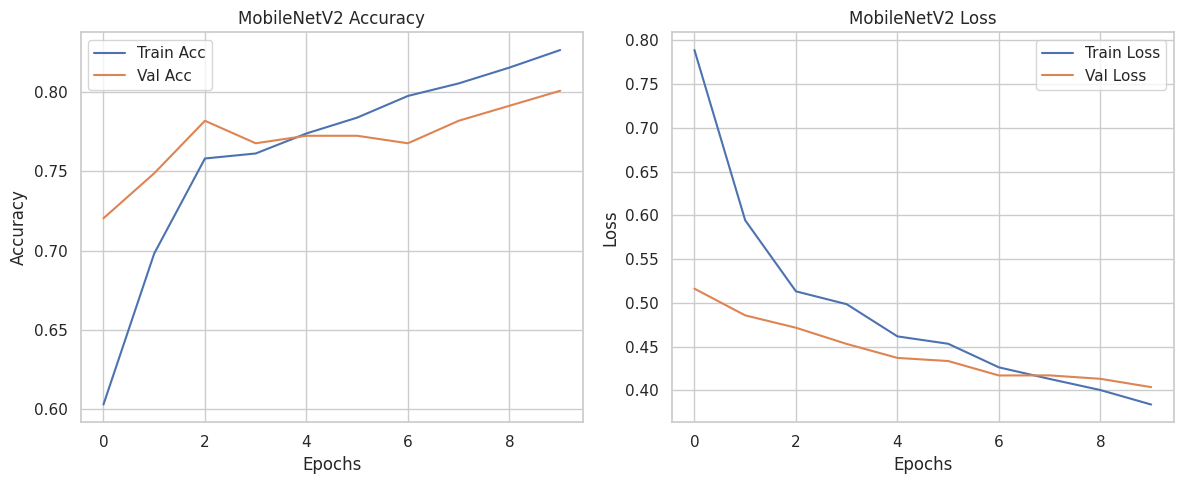

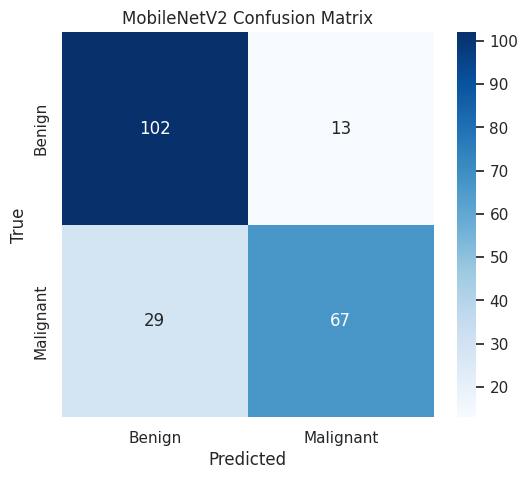


 Training model: ResNet50
Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 31s 287ms/step - accuracy: 0.5794 - loss: 0.7413 - val_accuracy: 0.6872 - val_loss: 0.5644
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.6457 - loss: 0.6364 - val_accuracy: 0.7156 - val_loss: 0.5423
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.7182 - loss: 0.5788 - val_accuracy: 0.7299 - val_loss: 0.5331
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.7086 - loss: 0.5818 - val_accuracy: 0.7299 - val_loss: 0.5272
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 112ms/step - accuracy: 0.7168 - loss: 0.5685 - val_accuracy: 0.7251 - val_loss: 0.5261
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.7047 - loss: 0.5743 - val_accuracy: 0.7393 - val_loss: 0.5170
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - accuracy: 0.7243 - loss: 0.5524 - val_accuracy: 0.7536 - val_loss: 0.5098
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.7207 - los

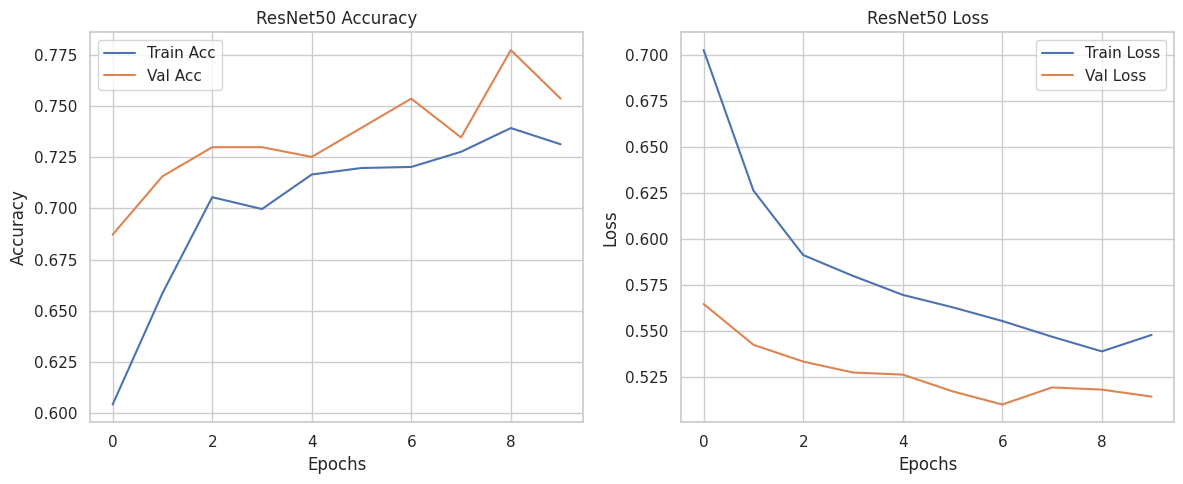

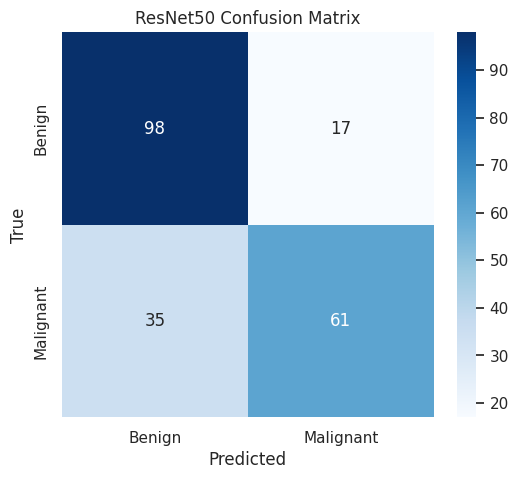

In [20]:
# Define architectures
architectures = {
    "VGG16": lambda: build_transfer_model(VGG16),
    "DenseNet201": lambda: build_transfer_model(DenseNet201),
    "Xception": lambda: build_transfer_model(Xception),
    "MobileNetV2": lambda: build_transfer_model(MobileNetV2),
    "ResNet50": lambda: build_transfer_model(ResNet50)
}

results = {}

for name, model_fn in architectures.items():
    print(f"\n Training model: {name}")
    model = model_fn()

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=10,
        callbacks=[],
        verbose=1
    )

    # Get best val accuracy and its epoch
    val_acc = history.history.get("val_accuracy", [])
    if val_acc:
        best_epoch = np.argmax(val_acc)
        best_val_acc = val_acc[best_epoch]
    else:
        best_val_acc = 0

    y_pred = model.predict(val_ds)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.concatenate([y for _, y in val_ds])
    y_true_classes = np.argmax(y_true, axis=1)

    print(f"\n{name} Accuracy : {best_val_acc:.4f}")
    print(f"Classification Report for {name}:\n{classification_report(y_true_classes, y_pred_classes)}")

    plot_learning_curves(history, name)
    plot_confusion_matrix(y_true_classes, y_pred_classes, name)

    results[name] = {"model": model, "history": history}
    model.save(f"{name}_model.h5")


### Model Performance Summary & Visualization

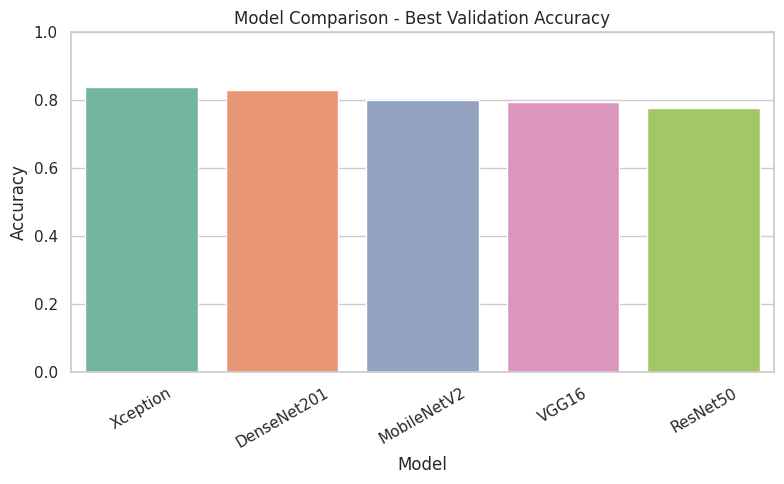

         Model  Best Validation Accuracy
2     Xception                  0.838863
1  DenseNet201                  0.829384
3  MobileNetV2                  0.800948
0        VGG16                  0.796209
4     ResNet50                  0.777251


In [21]:

# Gather best validation accuracy from results dictionary
model_names = []
accuracies = []

for model_name, data in results.items():
    history = data["history"].history
    val_acc = history.get("val_accuracy", history.get("accuracy", []))
    best_val_acc = max(val_acc) if val_acc else 0
    model_names.append(model_name)
    accuracies.append(best_val_acc)

# Create DataFrame for plotting
df = pd.DataFrame({
    "Model": model_names,
    "Best Validation Accuracy": accuracies
}).sort_values(by="Best Validation Accuracy", ascending=False)

# Plot bar chart
plt.figure(figsize=(8, 5))

sns.barplot(data=df, x="Model", y="Best Validation Accuracy", palette="Set2")
plt.title("Model Comparison - Best Validation Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Optional: print table
print(df)



# **Model Testing**

 ## Skin Tone–Wise Evaluation of Trained Models

Evaluates trained models on grouped skin tone test data.

- **Loads each model** (`VGG16`, `DenseNet201`, `Xception`, etc.)
- **For each skin tone group**:
  - Loads and preprocesses test images
  - Normalizes using group-specific statistics
  - Runs predictions and calculates accuracy
- **Stores per-group accuracy** in a dictionary for later comparison and visualization

In [22]:
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from PIL import Image
import cv2


# Define preprocessing
def preprocess(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

# Function to load images from a skin type folder (newly defined)
def load_images_from_skin_type_folder(folder_path):
    """Loads images and labels from a folder containing benign and malignant subfolders."""
    images = []
    labels = []
    for category in ["benign", "malignant"]:  # Assuming your subfolders are named 'benign' and 'malignant'
        category_path = os.path.join(folder_path, category)
        if os.path.exists(category_path):
            for filename in os.listdir(category_path):
                if filename.lower().endswith((".png", ".jpg", ".jpeg")):
                    img_path = os.path.join(category_path, filename)
                    try:
                        # Load image using Pillow and convert to RGB
                        img = Image.open(img_path).convert("RGB")
                        img = np.array(img)

                        # Convert the image from RGB to BGR
                        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

                        images.append(img)
                        labels.append(category)
                    except Exception as e:
                        print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels)

# Load grouped test data
skin_tone_base = "Grouped_Images"
skin_types = os.listdir(skin_tone_base)

# Define your saved model names and file paths
model_files = {
    # "CustomCNN": "CustomCNN_model.h5",
    "VGG16": "VGG16_model.h5",
    "DenseNet201": "DenseNet201_model.h5",
    "Xception": "Xception_model.h5",
    "MobileNetV2": "MobileNetV2_model.h5",
    "ResNet50": "ResNet50_model.h5"
}

# Store accuracy results
results = {model_name: {} for model_name in model_files.keys()}

# Evaluate each model on each skin tone group
for model_name, model_path in model_files.items():
    print(f"\nLoading model: {model_name}")
    model = load_model(model_path)

    for skin_type in skin_types:
        skin_type_path = os.path.join(skin_tone_base, skin_type)
        print(f"\nEvaluating {model_name} on skin type group: {skin_type}")

        # Load images and labels from the group
        X, y_labels = load_images_from_skin_type_folder(skin_type_path)
        if len(X) < 20:
            print("Too few samples. Skipping...")
            continue

        # Encode labels
        le = LabelEncoder()
        y = le.fit_transform(y_labels)

        # Normalize per skin group
        mean = np.mean(X, axis=(0, 1, 2), keepdims=True)
        std = np.std(X, axis=(0, 1, 2), keepdims=True)
        std[std == 0] = 1e-6
        X_norm = (X - mean) / std

        # Prepare validation dataset
        val_ds = (tf.data.Dataset.from_tensor_slices((X_norm, y))
                  .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
                  .batch(32)
                  .prefetch(tf.data.AUTOTUNE))

        # Predict
        y_pred = model.predict(val_ds)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true = np.argmax(tf.keras.utils.to_categorical(y), axis=1)

        # Accuracy
        acc = accuracy_score(y_true, y_pred_classes)
        print(f"Accuracy for {model_name} on {skin_type}: {acc:.4f}")
        results[model_name][skin_type] = acc


Loading model: VGG16

Evaluating VGG16 on skin type group: Type III (FST3) Medium skin tone
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step
Accuracy for VGG16 on Type III (FST3) Medium skin tone: 0.8021

Evaluating VGG16 on skin type group: Type II (FST2) Fair skin
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step 
Accuracy for VGG16 on Type II (FST2) Fair skin: 0.6394

Evaluating VGG16 on skin type group: Type IV (FST4) Olive skin tone
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 323ms/step
Accuracy for VGG16 on Type IV (FST4) Olive skin tone: 0.7799

Loading model: DenseNet201

Evaluating DenseNet201 on skin type group: Type III (FST3) Medium skin tone
28/28 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step 
Accuracy for DenseNet201 on Type III (FST3) Medium skin tone: 0.8227

Evaluating DenseNet201 on skin type group: Type II (FST2) Fair skin
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step 
Accuracy for DenseNet201 on Type II (FST2) Fair skin: 0.7019

Evaluating DenseNet201 on skin type group: Type IV (FST4) Olive skin tone
33/33 ━━━━━━━━━━━━

## Skin Tone–Wise Accuracy Comparison Across Models

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



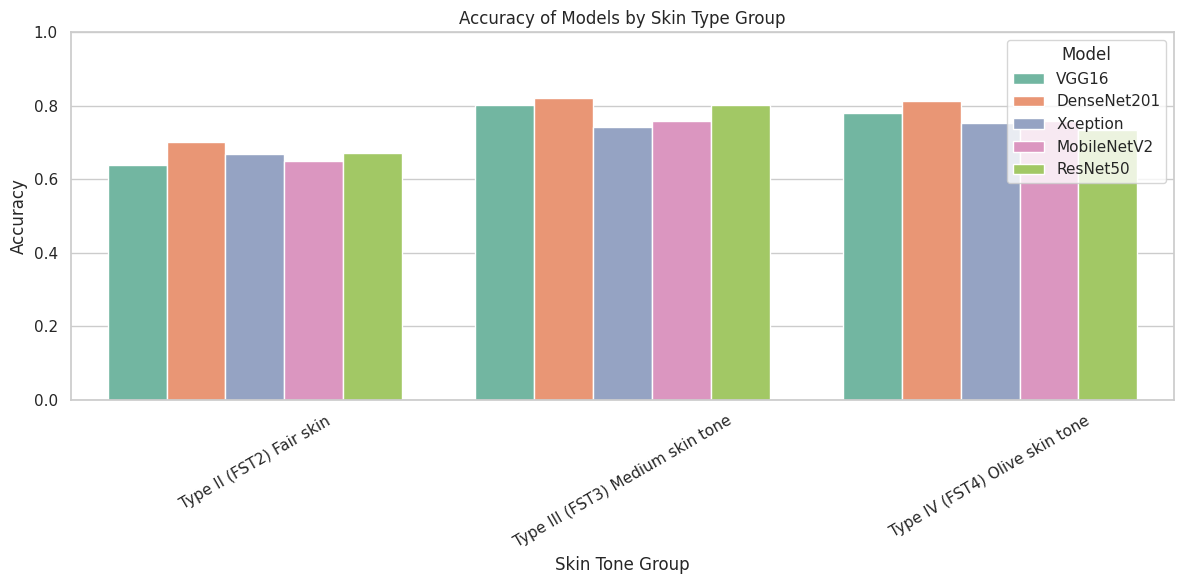

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert nested dict to long-form DataFrame
plot_data = []
for model_name, skin_dict in results.items():
    for skin_type, acc in skin_dict.items():
        plot_data.append({"Model": model_name, "Skin Type": skin_type, "Accuracy": acc})

df_plot = pd.DataFrame(plot_data)

# Sort skin types for consistent x-axis order
df_plot["Skin Type"] = pd.Categorical(df_plot["Skin Type"], categories=sorted(df_plot["Skin Type"].unique()), ordered=True)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_plot, x="Skin Type", y="Accuracy", hue="Model", palette="Set2")

plt.title("Accuracy of Models by Skin Type Group")
plt.ylabel("Accuracy")
plt.xlabel("Skin Tone Group")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.legend(title="Model")
plt.tight_layout()
plt.show()
